# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1</center>
## <center>Checkpoint 4 : Redes Neuronales</center> 

# Consigna

  1. Construir una **red neuronal para clasificación y mejorar su performance** mediante la búsqueda de arquitectura e hiperparámetros adecuados.
  
  2. **Evaluar la performance** de todos los modelos en entrenamiento y validación explicar todas las **métricas** y mostrar la matriz de confusión.
  
  3. **Generar predicciones** con el conjunto de test y realizar los submits correspondientes en la competencia de Kaggle.

  4. Generar las **conclusiones finales del trabajo** práctico evaluando la performance de todos los modelos entrenados.

# Inicializacion de entorno

## Librerías

In [1]:
!pip install dtreeviz


In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from datetime import datetime, timezone, timedelta
import time

#redes neuronales
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier   


#metricas
from sklearn.metrics import(
    confusion_matrix,
    classification_report,
    make_scorer,
    recall_score, 
    accuracy_score,
    f1_score,
    precision_score
)

#guardado 
from google.colab import files
import pickle

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

plt.style.use('ggplot')

## Funciones

### Métricas

In [3]:
def timer_flag(t):
    time_format = time.strftime("%M:%S", time.gmtime(round(t)))
    print("Tiempo transcurrido: ", time_format, " minutos")
    print("_______________________________")

In [4]:
def metricas_cv(model, t=None):
  print("Resultados del Cross Validation")
  print("_______________________________")
  timer_flag(t)
  #Mejores hiperparametros
  print("Mejores hiperparametros: ", model.best_params_)
  #Mejor métrica
  print("Mejor métrica F1: ",model.best_score_)

In [5]:
def obtener_metrica_rn(y_true, y_pred, m):
    m.update_state(y_true, y_pred)
    return m.result().numpy()

def obtener_metricas(matriz):
    tn = matriz[0][0].astype(int)
    tp = matriz[1][1].astype(int)
    fn = matriz[1][0].astype(int)
    fp = matriz[0][1].astype(int)

    accuracy= (tp+tn) / (tp+tn+fp+fn) 
    recall= tp / (tp+fn)
    precision= tp / (tp+fp)
    f1= 2*((precision*recall)/(precision+recall+ keras.backend.epsilon()))
    
    return [[str(round(accuracy,5)), str(round(recall,5)), str(round(precision,5)), str(round(f1,5))]]

def metricas_rn(true, pred, title="Matriz de confusión y métricas para una red neuronal"):

  matriz=confusion_matrix(true, pred)
 
  metrics=obtener_metricas(matriz)
  labels=['Accuracy', 'Recall', 'Precision', 'F1']
  
  plt.title(title)
  t = plt.table(cellText=metrics,
                colLabels=labels,
                bbox=(1.5, .1, 0.75, 0.75))
  t.auto_set_font_size(False)
  t.set_fontsize(11)

  #Grafico la matriz de confusión
  sns.heatmap(matriz,cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')



La métricas para evaluar el rendimiento de un modelo se calculan comparando los valores predichos frente a los reales en un conjunto de testeo, es así que surgen diferentes valores:

*   **Matriz de confusión**:


|            | predicted    |            |            |
|:----------:|:------------:|:----------:|:----------:|
|            |              |      0     |       1    |
| real       |0             | TN         | FP         |
|            |1             | FN         | TP         |

**TN**: True Negative; **FN**: False Negative; **FP**: False Positive; **TP**: True Positive



---


*   **Precisión** (precision):
    \begin{align}
        precision=\frac{TP}{TP+FP}
    \end{align}

    La *precisión* indica que cuanto más se acerca a 1, menos falsos positivos tuvo y por lo tanto todos las predicciones sobre la positiva fueron correctas. Esta métrica valora la calidad del modelo.


---


*   **Exhaustividad** (recall):
    \begin{align}
        recall=\frac{TP}{TP+FN}
    \end{align}

    Si el *exhaustividad* se acerca a 1, quiere decir que no se quedó ningún negativo verdadero afuera. Esta métrica valora la cantidad de valores que pueden identificar del modelo. 


---


*   **F1**:
    \begin{align}
        F1=2.\frac{precision.recall}{precision+recall}
    \end{align}

    *F1* se utiliza para combinar las medidas de precision y recall en un sólo valor. Esto es práctico porque hace más fácil el poder comparar el rendimiento combinado de ambas métricas.


---


*   **Exactitud** (accuracy):
\begin{align}
    accuracy=\frac{TP+TN}{TP++TN+FP+FN}
\end{align}

  La *exactitud* indica cual es el porcentaje de aciertos del modelo. Sin embargo no brinda mucha información sobre cómo se distribuyen los valores.

    

### Train

In [8]:
def make_rn_prediction(model, x_data, y_data=None, submission=False):
    
    y_pred_pre = model.predict(x_data)
    
    bool_pred = np.where(y_pred_pre > 0.4, 1, 0).astype(int)  # Convertir a 1 O 0

    if(not submission): 
        metricas_rn(y_data, bool_pred)
    
    ds_validacion = pd.DataFrame(bool_pred).reset_index()
    
    return ds_validacion[0]

## Datasets

In [120]:
db_train_url = 'https://raw.githubusercontent.com/FranGuti/7506R-1C2023-GRUPO34/main/Datasets/processed/hotels_train.csv'
db_test_url = 'https://raw.githubusercontent.com/FranGuti/7506R-1C2023-GRUPO34/main/Datasets/processed/hotels_test.csv'

df_train = pd.read_csv(db_train_url)
df_test_submission = pd.read_csv(db_test_url)

Datasets reducidos a 20 dimensiones por Random Forest features_importace

In [ ]:
db_train_reduced_url = 'https://raw.githubusercontent.com/FranGuti/7506R-1C2023-GRUPO34/main/Datasets/reduced/hotels_train.csv'
db_test_reduced_url = 'https://raw.githubusercontent.com/FranGuti/7506R-1C2023-GRUPO34/main/Datasets/reduced/hotels_test.csv'

df_train_reduced = pd.read_csv(db_train_url)
df_test_submission_reduced = pd.read_csv(db_test_url)

# Preprocesamiento del dataframe

## Separación en x e y

Separacion entre columnas de decision y de target

In [11]:
#Creo un dataset con los features que voy a usar para clasificar
x_work = df_train.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
y_work = df_train['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(x_work,
                                                    y_work, 
                                                    test_size=0.25,  #proporcion 75/25
                                                    random_state=2, #semilla
                                                    stratify=df_work_train['is_canceled'].values) 

x_test_submission = df_test_submission.drop(['id'], axis='columns', inplace=False)                                            

In [121]:
#Creo un dataset con los features que voy a usar para clasificar
x_work = df_train_reduced.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
y_work = df_train_reduced['is_canceled'].copy()

x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = train_test_split(x_work,
                                                    y_work, 
                                                    test_size=0.25,  #proporcion 75/25
                                                    random_state=2, #semilla
                                                    stratify=df_work_train['is_canceled'].values) 

x_test_submission_reduced = df_test_submission_reduced.drop(['id'], axis='columns', inplace=False)  

# Entrenamiento y prediccion de redes

In [12]:
best_model_submission = {"name": "", "model": None}

Se buscan generar multiples modelos para distintas arquitecturas evaluando cual está mejor optimizado

Para ello utilizaremos el F1-score

In [13]:
def f1_score(y_true, y_pred):
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred, 0, 1)))
    possible_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + keras.backend.epsilon())
    recall = true_positives / (possible_positives + keras.backend.epsilon())

    f1_score = 2 * (precision * recall) / (precision + recall + keras.backend.epsilon())
    return f1_score

## Modelo 1: SGD + binary crossentropy

Una capa de entrada y una de salida con función de activación sigmoidea. Ambas de una neurona



In [14]:
# calcula la cantidad de clases
cant_clases=len(np.unique(y_train))
d_in=len(x_train.columns)

def get_arq1():
  return keras.Sequential([
    keras.layers.Dense(1,input_shape=(d_in,)),
    keras.layers.Dense(1, activation='sigmoid')])

arq_1 = get_arq1()
arq_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 40        
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


2023-05-25 17:38:32.866722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-25 17:38:32.867255: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Optimizada según F1-score con Stochastic Gradient Descent y función de perdida de entropía cruzada binaria

In [15]:
def compile_m1(arq):
  arq.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01), 
    loss='binary_crossentropy', 
    # metricas para ir calculando en cada iteracion o batch 
    metrics=[f1_score], 
  )

Compilo la arquitectura y las entreno en diversa cantidad de epochs y batch_size

In [16]:
cant_pruebas = 10
historias = []

for i in range(10, cant_pruebas * 10, 10):
  modelo_1 = get_arq1()
  compile_m1(modelo_1)
  historias.append(modelo_1.fit(x_train, y_train, epochs=i,batch_size=50,verbose=False))

In [17]:
historias[-1].history['loss'][-1]

0.49772635102272034

347/347 [==============================] - 0s 386us/step


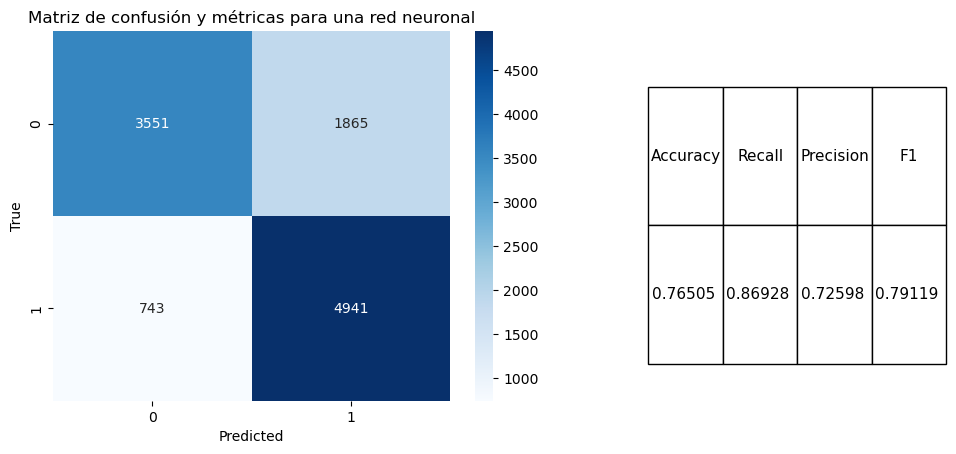

In [18]:
ds_validacion = make_rn_prediction(modelo_1, x_test, y_test)

## Modelo 2: Bi-Neuronal

Misma idea del Modelo 1 pero con dos neuronas en cada capa

In [19]:
# One hot encoding
enc = OneHotEncoder()
y_train_encoder = enc.fit_transform(y_train[:, np.newaxis]).toarray()
y_test_encoder = enc.transform(y_test[:, np.newaxis]).toarray()

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Dos neuronas con función de activación relu 

In [20]:
# calcula la cantidad de clases
cant_clases=len(np.unique(y_train))
d_in=len(x_train.columns)


def create_model_2():
    modelo= keras.Sequential([
        # input_shape solo en la primer capa
        #Capa con 3 salidas, activación relu
        keras.layers.Dense(2,input_shape=(d_in,), activation='relu',kernel_initializer='uniform'),
        keras.layers.Dense(cant_clases, activation='softmax')
    ])
    
    modelo.compile(
        optimizer=keras.optimizers.SGD(learning_rate=0.001), 
        loss='categorical_crossentropy', 
        # metricas para ir calculando en cada iteracion o batch 
        metrics=[f1_score], 
    )

    modelo.summary()
    
    return modelo


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 2)                 80        
                                                                 
 dense_21 (Dense)            (None, 2)                 6         
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


SGD como otpimizador segun f1, crossentropy para variables categoricas 
100 epochs, 16 batchs

In [21]:
modelo_2 = create_model_2()

historia = modelo_2.fit(x_train_scaled,y_train_encoder,epochs=100 ,batch_size=16,verbose=False)

In [22]:
y_pred_m2 = modelo_2.predict(x_test_scaled)
y_pred_m2_clases=np.argmax(y_pred_m2,axis=1).tolist()
y_real_clases=np.argmax(y_test_encoder,axis=1).tolist()

347/347 [==============================] - 0s 350us/step


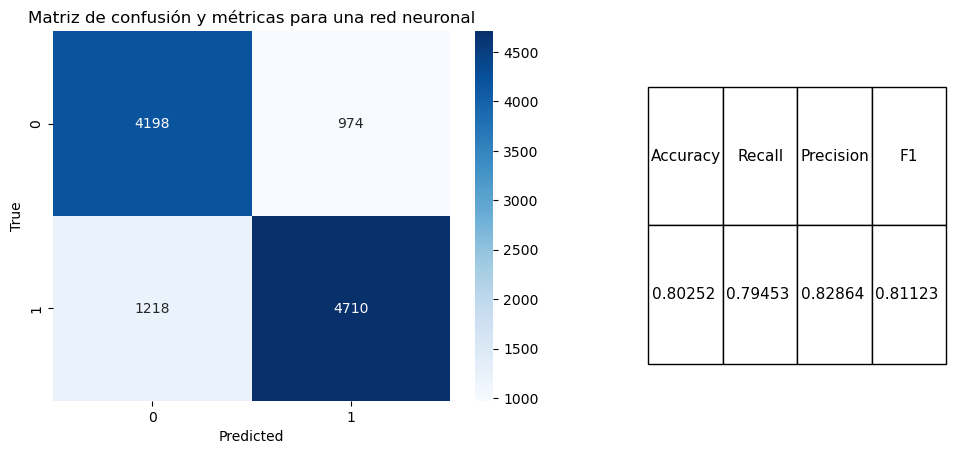

In [23]:
ds_validacion_m2=pd.DataFrame(y_pred_m2_clases,y_real_clases).reset_index()
ds_validacion_m2.columns=['y_pred','y_real']

metricas_rn(ds_validacion_m2.y_real, ds_validacion_m2.y_pred)

## Modelo 3: Tres capas con varias neuronas

Para este caso, utilizamos una capa de entrada de 64 neuronas, una capa intermedia de 32 y una capa de salida nuevamente con una función de activación sigmoideal, dado que se trata de una clasificación.
Para la optimización,  probamos con adma y una función de perdida binary crossentropy como en el modelo 1.

In [128]:
cant_clases=len(np.unique(y_train))
d_in=len(x_train.columns)

def create_model_3():
    modelo= keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(d_in,)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    modelo.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=[f1_score]
     )

    modelo.summary()
    
    return modelo

Model: "sequential_2364"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7081 (Dense)          (None, 64)                2560      
                                                                 
 dense_7082 (Dense)          (None, 32)                2080      
                                                                 
 dense_7083 (Dense)          (None, 1)                 33        
                                                                 
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


Para el modelo 3 utilizamos 40 epochs y un tamaño para el batch de 300, ademas de un early stopping para evitar un posible overfitting.

In [129]:
early_stopping = EarlyStopping(monitor='accuracy', patience = 1)

modelo_3 = create_model_3()

historia = modelo_3.fit(
    x_train,
    y_train,
    epochs=40,
    batch_size= 300,
    verbose=False, 
    callbacks = [early_stopping]
)

NotImplementedError: in user code:

    File "/home/martin-gp/anaconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/martin-gp/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1153, in f1_score  *
        zero_division=zero_division,
    File "/home/martin-gp/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1285, in fbeta_score  *
        _, _, f, _ = precision_recall_fscore_support(
    File "/home/martin-gp/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1568, in precision_recall_fscore_support  *
        labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
    File "/home/martin-gp/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1374, in _check_set_wise_labels  *
        y_type, y_true, y_pred = _check_targets(y_true, y_pred)
    File "/home/martin-gp/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 87, in _check_targets  *
        type_true = type_of_target(y_true, input_name="y_true")
    File "/home/martin-gp/anaconda3/lib/python3.10/site-packages/sklearn/utils/multiclass.py", line 298, in type_of_target  *
        if is_multilabel(y):
    File "/home/martin-gp/anaconda3/lib/python3.10/site-packages/sklearn/utils/multiclass.py", line 161, in is_multilabel  *
        y = xp.asarray(y)
    File "/home/martin-gp/anaconda3/lib/python3.10/site-packages/sklearn/utils/_array_api.py", line 75, in asarray  *
        return numpy.asarray(x, dtype=dtype)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (Cast_19:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.


347/347 [==============================] - 0s 352us/step


0        1
1        0
2        1
3        1
4        1
        ..
11095    1
11096    1
11097    1
11098    0
11099    0
Name: 0, Length: 11100, dtype: int64

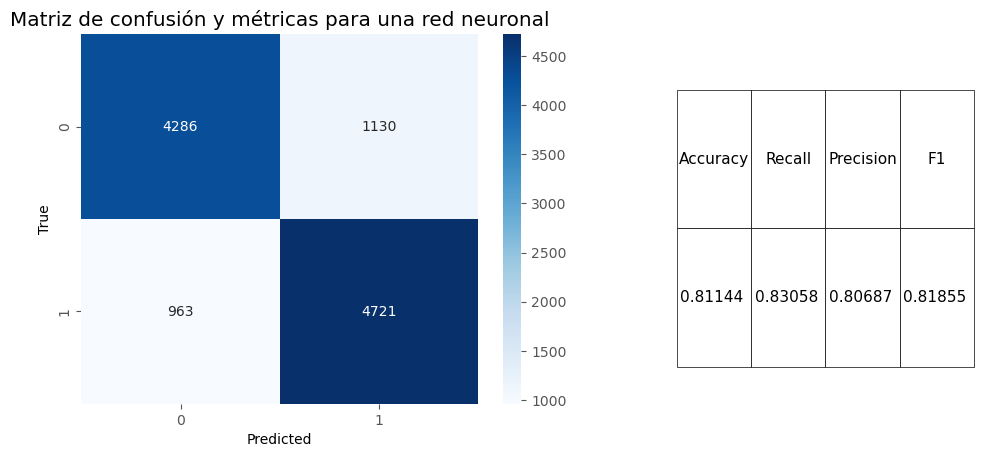

In [119]:
make_rn_prediction(modelo_3, x_test, y_test)

## Modelo 4: Tres capas hiperparametrizadas con Grid Search

In [130]:
cant_clases=len(np.unique(y_train_reduced))
d_in = len(x_train_reduced.columns)

En este caso mantuvimos la arquitectura del modelo 3 pero utilizando como optimizador a nadam, como funcion de perdida a MSE, y métrica principal la exactitud.

In [132]:
def create_model_4():
    modelo= keras.Sequential([
      keras.layers.Dense(64, activation='relu', input_shape=(d_in,)),
      keras.layers.Dense(32, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')
    ])
    
    modelo.compile(
      optimizer='nadam', 
      loss='mse', 
      metrics=["accuracy"], 
    )
    
    return modelo

Para optener la cantidad de epochs y el tamaño de batch adecuado, realizamos una validación cruzada con Grid Search. Es importe destacar que para este caso, se utilizó un dataset reducido en su dimensión a partir de la importacia de atributos conseguida en el CHP3 por Random Forest.

In [134]:
modelo_cv = KerasClassifier(build_fn=create_model_4)

epochs = [100, 200, 300]
batches = [20, 40, 60]

param_grid = dict( epochs=epochs, batch_size=batches)

print(param_grid)

grid = GridSearchCV(estimator=modelo_cv, param_grid=param_grid)
grid_result = grid.fit(x_train_reduced, y_train_reduced, callbacks = [early_stopping])

{'epochs': [100, 200, 300], 'batch_size': [20, 40, 60]}
Epoch 1/100
1332/1332 [==============================] - 1s 569us/step - loss: 0.1668 - accuracy: 0.7532
Epoch 2/100
1332/1332 [==============================] - 1s 579us/step - loss: 0.1450 - accuracy: 0.7907
Epoch 3/100
1332/1332 [==============================] - 1s 572us/step - loss: 0.1355 - accuracy: 0.8024
Epoch 4/100
1332/1332 [==============================] - 1s 580us/step - loss: 0.1347 - accuracy: 0.8033
Epoch 5/100
1332/1332 [==============================] - 1s 580us/step - loss: 0.1283 - accuracy: 0.8119
Epoch 6/100
1332/1332 [==============================] - 1s 584us/step - loss: 0.1281 - accuracy: 0.8095
Epoch 7/100
1332/1332 [==============================] - 1s 565us/step - loss: 0.1243 - accuracy: 0.8185
Epoch 8/100
1332/1332 [==============================] - 1s 577us/step - loss: 0.1230 - accuracy: 0.8201
Epoch 9/100
1332/1332 [==============================] - 1s 583us/step - loss: 0.1207 - accuracy: 0.8235

In [135]:
print("Mejor modelo: %f %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor modelo: 0.845105 {'batch_size': 40, 'epochs': 300}


278/278 [==============================] - 0s 344us/step


0        1
1        0
2        1
3        1
4        1
        ..
11095    1
11096    1
11097    1
11098    0
11099    1
Name: 0, Length: 11100, dtype: int64

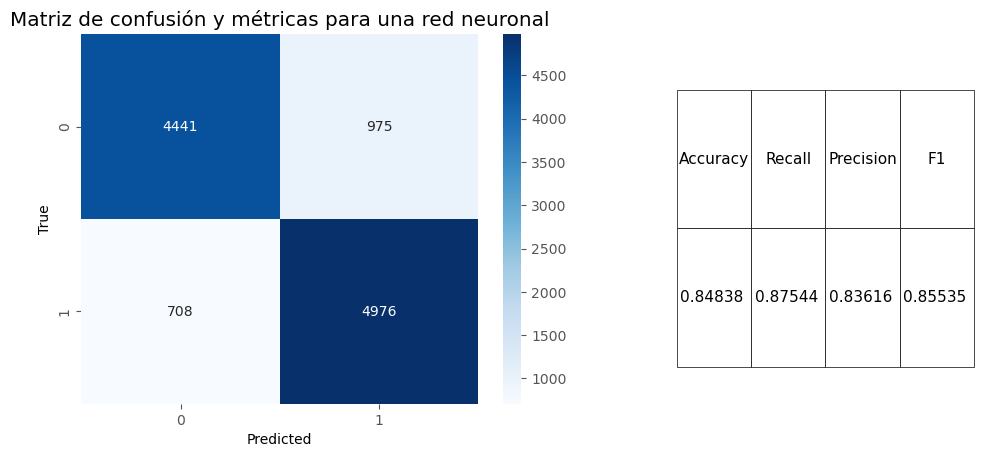

In [136]:
modelo_4 = grid_result.best_estimator_
make_rn_prediction(modelo_4, x_test_reduced, y_test_reduced)

In [137]:
best_model_submission["name"] = "RN-Multicapa-nadam-mse-GridSearch"
best_model_submission["model"] = modelo_4

# Conclusiones de los modelos

# Submission

Se realiza una prediccion a partir de las columnas de decision del dataframe de test

In [138]:
y_pred = make_rn_prediction(best_model_submission["model"], x_test_submission, submission=True)
df_submission = pd.DataFrame({"id": df_test_submission["id"], "is_canceled": y_pred})
df_submission

664/664 [==============================] - 0s 353us/step


,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
...,...,...
26530,636ccded-66ad-4538-8006-c0b9f84c6256,0
26531,11e19741-bd28-4459-8ea3-184f1664000f,0
26532,36a4c7b0-d6b1-4528-93db-311be96ec1c6,1
26533,89c85fa5-2b3d-4131-844c-e151a65ca240,1


In [139]:
file_name = 'submission-' + best_model_submission["name"] + '-' + datetime.now(timezone(timedelta(hours=-3))).strftime("%d-%m-%H:%M") + '.csv'
df_submission.to_csv(file_name, encoding = 'utf-8-sig', index=False) 
files.download(file_name)

In [140]:
model_file_name = best_model_submission["name"] + ".pickle"

# save model
pickle.dump(best_model_submission["model"], open(model_file_name, "wb"))

INFO:tensorflow:Assets written to: ram://2c017b32137045d29ac202fb4cc2b536/assets


INFO:tensorflow:Assets written to: ram://2c017b32137045d29ac202fb4cc2b536/assets
